<a href="https://colab.research.google.com/github/Aritro30/Texture-Synthesis/blob/main/CPSC425Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#unzipping files
from zipfile import ZipFile
ZipFile('hw3_images.zip').extractall()


**Number - 4 and 5**



In [ ]:
# Library Imports
from PIL import Image, ImageDraw
import numpy as np
import random
import os.path
import pickle

In [ ]:
##############################################################################
#                            Some helper functions                           #
##############################################################################

def DrawBox(im,x1,y1,x2,y2):
	draw = ImageDraw.Draw(im)
	draw.line((x1,y1,x1,y2),fill="white",width=1)
	draw.line((x1,y1,x2,y1),fill="white",width=1)
	draw.line((x2,y2,x1,y2),fill="white",width=1)
	draw.line((x2,y2,x2,y1),fill="white",width=1)
	del draw
	return im

def Find_Edge(hole_mask):
	[cols, rows] = np.shape(hole_mask)
	edge_mask = np.zeros(np.shape(hole_mask))
	for y in range(rows):
		for x in range(cols):
			if (hole_mask[x,y] == 1):
				if (hole_mask[x-1,y] == 0 or
						hole_mask[x+1,y] == 0 or
						hole_mask[x,y-1] == 0 or
						hole_mask[x,y+1] == 0):
					edge_mask[x,y] = 1
	return edge_mask

In [ ]:
##############################################################################
#                        Functions for you to complete                       #
##############################################################################

def ComputeSSD(TODOPatch, TODOMask, textureIm, patchL):
	#convert each array to double/float for computations
	TODOPatch = np.float32(TODOPatch.copy())
	TODOMask = np.float32(TODOMask.copy())
	textureIm = np.float32(textureIm.copy())
	#compute number of rows and columns for patch, SSD
	patch_rows, patch_cols, patch_bands = np.shape(TODOPatch)
	tex_rows, tex_cols, tex_bands = np.shape(textureIm)
	ssd_rows = tex_rows - 2 * patchL
	ssd_cols = tex_cols - 2 * patchL
	SSD = np.zeros((ssd_rows,ssd_cols))
	for r in range(ssd_rows):
		for c in range(ssd_cols):
			#the sum of difference is stored in variable "total"
			#total is initialised with zero
			total = 0.0
			#run loop for each row in the patch
			for i in range(patch_rows):
				#run loop for each column in the patch
				for j in range(patch_cols):
					#check if there is an element in the TODOPatch cell
					if TODOMask[i][j] == 0:
						#if there is an useful element in the TODOPatch, 
						#we find the sum of squared difference between textureIm and TODOPatch 
						#we get 3 SSD values for the 3 color channels. We sum them up and then add to the total
						total = total + sum((textureIm[r+i][c+j]-TODOPatch[i][j])**2)
			#store the total in the SSD cell
			SSD[r][c] = total
	#return the array containing the total of squared difference
	return SSD	
def CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iMatchCenter,jMatchCenter,patchL):
	patchSize = 2 * patchL + 1
	for i in range(patchSize):
		for j in range(patchSize):
			# Copy the selected patch selectPatch into the image containing
			# the hole imHole for each pixel where TODOMask = 1.
			# The patch is centred on iPatchCenter, jPatchCenter in the image imHole
			#
			# ADD YOUR CODE HERE
			#-----------------------------------------------------------------------
			#check if there is an empty element waiting to be filled in
			if TODOMask[i][j] == 1:
				#if yes, copy the values from textureIm
				imHole[iPatchCenter-patchL+i][jPatchCenter-patchL+j] = textureIm[iMatchCenter-patchL+i][jMatchCenter-patchL+j]

	#return imHole after filling the hole		
	return imHole


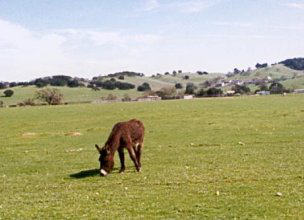

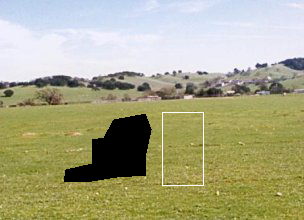

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3473
Number of pixels remaining =  1085
Number of pixels remaining =  24


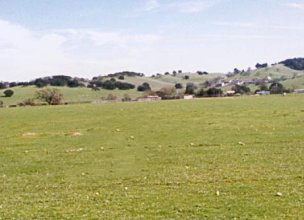

In [ ]:
##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 10
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 1

# Display results interactively
showResults = True

#
# Read input image
#

im = Image.open('donkey.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
fill_region_file = open('fill_region.pkl', 'rb')
fillRegion = pickle.load( fill_region_file )
fill_region_file.close()

texture_region_file = open('texture_region.pkl', 'rb')
textureRegion = pickle.load( texture_region_file )
texture_region_file.close()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	display(im)
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	display(im1)
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	display(Image.fromarray(imHole).convert('RGB'))
Image.fromarray(imHole).convert('RGB').save('results.jpg')


**Number - 6**

**Good performance with patchL = 2 and randomPatchSD = 3**

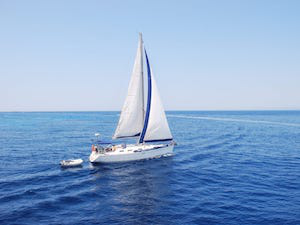

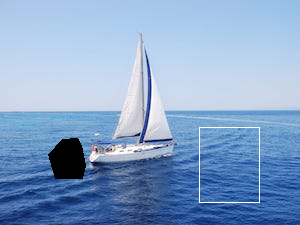

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  1230
Number of pixels remaining =  859
Number of pixels remaining =  545
Number of pixels remaining =  302
Number of pixels remaining =  125
Number of pixels remaining =  16


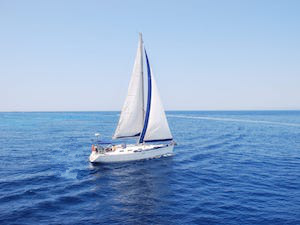

In [ ]:
##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 2
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 3

# Display results interactively
showResults = True

#
# Read input image
#

im = Image.open('example1.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
fill_region_file = open('fill_region1.pkl', 'rb')
fillRegion = pickle.load( fill_region_file )
fill_region_file.close()

texture_region_file = open('texture_region1.pkl', 'rb')
textureRegion = pickle.load( texture_region_file )
texture_region_file.close()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	display(im)
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	display(im1)
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	display(Image.fromarray(imHole).convert('RGB'))
Image.fromarray(imHole).convert('RGB').save('results.jpg')


**Poor performance with patchL = 20 and randomPatchSD = 0**

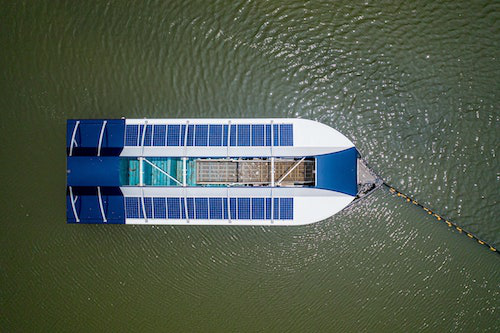

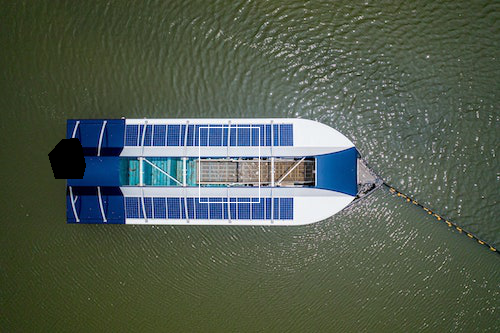

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  1230


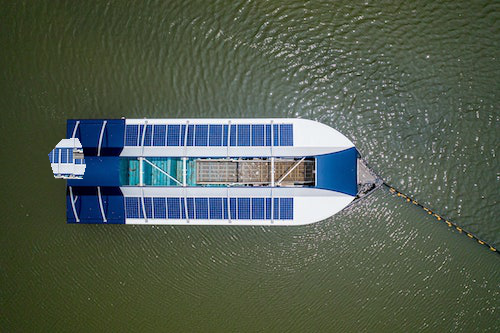

In [ ]:
##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 20
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 0

# Display results interactively
showResults = True

#
# Read input image
#

im = Image.open('example4.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
fill_region_file = open('fill_region1.pkl', 'rb')
fillRegion = pickle.load( fill_region_file )
fill_region_file.close()

texture_region_file = open('texture_region1.pkl', 'rb')
textureRegion = pickle.load( texture_region_file )
texture_region_file.close()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	display(im)
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	display(im1)
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	display(Image.fromarray(imHole).convert('RGB'))
Image.fromarray(imHole).convert('RGB').save('results.jpg')


The second image performed poorly due to a number of reasons:

1) The selection of textureIm **(in the additional example image of the boat that was provided)** had a problem. If you notice, the white rectangle was chosen at the centre of the boat. However, we had to fill the hole at the edge of the boat. As a result, proper match between the patch and the textureIm was very difficult to find. Hence, we can see a poor result. 

2) I selected a very large patchL (20) and a very small randomPatchSD value (0). Large patchL means that we are using a large patch. When the patch is large, we have to locally match more details and large structures. We will get few matches/matching neighborhoods. As a result, we see repeatitiveness and a poor result. Moreover, a small randomPatchSD means less standard deviation. We only choose the best match. Hence, we see poor result.

**No-7**

1) Increase patchL will mean that our patch size will be bigger. We will have large structures to match. Hence, the number of matching neighborhoods will decrease. We will have less number of matches to choose from. As a result, we will see a more regular and repetitive pattern.

2) Increase in randomPatchSD will mean that patch choice will be more random. We will choose a different variety of neighborhood match at each time. As a result, we will see a less regular and repetitive pattern. However, the image will be more realistic.

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc


Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp "./drive/My Drive/Colab Notebooks/CPSC425Assignment-3.ipynb" ./


In [ ]:
!jupyter nbconvert --to PDF "CPSC425Assignment-3.ipynb"

[NbConvertApp] Converting notebook CPSC425Assignment-3.ipynb to PDF
[NbConvertApp] Support files will be in CPSC425Assignment-3_files/
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Making directory ./CPSC425Assignment-3_files
[NbConvertApp] Writing 83780 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConv

In [ ]:
file1 = open("/content/drive/My Drive/hw5/sift/train/Bedroom/image_0001.jpg.txt","r")
print (file1.read())  

5.407071590423583984e+00,1.205377883911132812e+02,6.000000000000000000e+00,3.100000000000000000e+01,1.800000000000000000e+01,1.000000000000000000e+00,2.000000000000000000e+00,3.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,2.000000000000000000e+00,8.000000000000000000e+00,3.500000000000000000e+01,2.000000000000000000e+01,1.000000000000000000e+00,1.000000000000000000e+00,1.400000000000000000e+01,6.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,9.000000000000000000e+00,1.500000000000000000e+01,2.000000000000000000e+00,2.000000000000000000e+00,2.400000000000000000e+01,3.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,2.100000000000000000e+01,9.000000000000000000e+00,1.400000000000000000e+01,3.000000000000000000e+00,2.000000000000000000e+01,7.000000000000000000e+01,